In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import preprocessing
import plotly.plotly as py
py.sign_in('wgopar', 'y3jt1ddvvu')
import plotly.graph_objs as go
%matplotlib inline

In [2]:
def preprocess(filename):
    """Preprocess NCDC weather data"""

    fields = ['STN', 'WBAN', 'YEARMODA', 'TEMP', 'TEMP_count', 'DEWP', 'DEWP_count', 'SLP', 'SLP_count', 'STP', 'STP_count', 'VISIB', 'VISIB_count', 'WDSP', 'WDSP_count', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP', 'FRSHTT']
     
    df = pd.read_csv(filename, 
                  sep=r'\s+', 
                  names=fields, 
                  header=0, 
                  parse_dates=['YEARMODA'], 
                  na_values={'TEMP':[9999.9], 
                             'DEWP':[9999.9], 
                             'SLP':[9999.9], 
                             'STP':[9999.9], 
                             'VISIB':[999.9], 
                             'WDSP':[999.9], 
                             'MXSPD':[999.9], 
                             'GUST':[999.9], 
                             'MAX':['9999.9'], # doesn't matter whether float or str
                             'MIN':['9999.9'], 
                             'PRCP':['99.99'],
                             'SNDP':[999.9]}
                 )
    flagged = df.copy()
 
    def strip_flag(x):
        if type(x) is float:
            return x
        elif type(x) is str:
            return float(x[:-1]) if '*' in x else float(x)
    def extract_flag(x):
        if type(x) is float:
            return False
        elif type(x) is str:
            return True if '*' in x else False
     
    flagged['MAX'] = df['MAX'].map(strip_flag)
    flagged['MAX_flag'] = df['MAX'].map(extract_flag)
    flagged['MIN'] = df['MIN'].map(strip_flag)
    flagged['MIN_flag'] = df['MIN'].map(extract_flag)
     
    flagged['PRCP'] = df['PRCP'].map(lambda x: float(x[:-1]) if type(x) is str else x)
    PRCP_flag = df['PRCP'].map(lambda x: x[-1] if type(x) is str else x)
    PRCP_dummies = pd.get_dummies(PRCP_flag).add_prefix('PRCP_')
    preprocessed = flagged.join(PRCP_dummies)
     
    return preprocessed

In [3]:
""" Take Nov. 81'-14' """
print ("processing 1...")
df1 = preprocess('CA_1981-1985.txt')
print ("processing 2...")
df2 = preprocess('CA_1985-1989.txt')
print ("processing 3...")
df3 = preprocess('CA_1989-1993.txt')
print ("processing 4...")
df4 = preprocess('CA_1993-1997.txt')
print ("processing 5...")
df5 = preprocess('CA_1997-2001.txt')
print ("processing 6...")
df6 = preprocess('CA_2001-2005.txt')
print ("processing 7...")
df7 = preprocess('CA_2005-2009.txt')
print ("processing 8...")
df8 = preprocess('CA_2009-2014.txt')


processing 1...
processing 2...
processing 3...
processing 4...
processing 5...
processing 6...
processing 7...
processing 8...


In [21]:
""" combine all data frames """
frames = [df1, df2, df3, df4, df5, df6, df7, df8]
df = pd.concat(frames)
df_processed = df[['STN','YEARMODA', 'TEMP', 'DEWP', 'PRCP']].dropna(axis=0)
df_processed = df_processed.set_index('YEARMODA')

In [22]:
print df_processed.head()

               STN  TEMP  DEWP  PRCP
YEARMODA                            
1985-05-11  691414  45.0  42.9  0.00
1985-05-14  691414  47.5  47.1  0.08
1985-05-15  691414  53.4  49.7  0.00
1985-05-16  691414  56.4  53.7  0.00
1985-05-17  691414  55.6  52.4  0.00


In [23]:
""" Get sd, sf,la weather from november 1981-2014"""


""" San Diego """
df_sd = df_processed[df_processed['STN'] == 722900]
""" San Francisco """
df_sf = df_processed[df_processed['STN'] == 724940]
""" Los Angeles """
df_la = df_processed[df_processed['STN'] == 722950]

def subset(df):
    df_processed = df.resample('W')
    return df_processed[df_processed.index.month == 11]

df_sd_processed = df_sd.groupby('STN').apply(subset)
df_sd_processed = df_sd_processed.dropna(axis=0)

df_sf_processed = df_sf.groupby('STN').apply(subset)
df_sf_processed = df_sf_processed.dropna(axis=0)

df_la_processed = df_la.groupby('STN').apply(subset)
df_la_processed = df_la_processed.dropna(axis=0)

print (df_sd_processed.shape)
print (df_sf_processed.shape)
print (df_la_processed.shape)
print (df_sd.head())

(134, 4)
(134, 4)
(134, 4)
               STN  TEMP  DEWP  PRCP
YEARMODA                            
1981-11-01  722900  67.5  36.2     0
1981-11-02  722900  70.5  35.0     0
1981-11-03  722900  68.4  41.7     0
1981-11-04  722900  64.9  59.0     0
1981-11-05  722900  64.0  57.8     0


In [24]:
""" normalize data in data frames """
df_sd_processed[['TEMP','DEWP','PRCP']] = preprocessing.scale(df_sd_processed[['TEMP','DEWP','PRCP']].values)
df_sf_processed[['TEMP','DEWP','PRCP']] = preprocessing.scale(df_sf_processed[['TEMP','DEWP','PRCP']].values)
df_la_processed[['TEMP','DEWP','PRCP']] = preprocessing.scale(df_la_processed[['TEMP','DEWP','PRCP']].values)

""" Save data from dataframes """
sd_data_normed = df_sd_processed[['TEMP','DEWP','PRCP']].values
sf_data_normed = df_sf_processed[['TEMP','DEWP','PRCP']].values
la_data_normed = df_la_processed[['TEMP','DEWP','PRCP']].values

print df_sd_processed.head()

print sd_data_normed[0:10]

                      STN      TEMP      DEWP      PRCP
STN    YEARMODA                                        
722900 1981-11-01  722900  1.892658 -2.388587 -0.299688
       1981-11-08  722900  1.459608  0.273097 -0.299688
       1981-11-15  722900  0.705593  1.404188 -0.299688
       1981-11-22  722900  0.160461  0.829904 -0.299688
       1981-11-29  722900 -0.664880  0.822413  1.537517
[[ 1.89265768 -2.38858689 -0.29968763]
 [ 1.45960845  0.27309729 -0.29968763]
 [ 0.70559333  1.40418821 -0.29968763]
 [ 0.16046077  0.82990364 -0.29968763]
 [-0.66488011  0.82241297  1.5375168 ]
 [ 1.15902134 -1.23252706 -0.29968763]
 [-0.86866798 -0.53090112  0.97222313]
 [ 0.23178653  0.48533289 -0.12808063]
 [-0.364293   -0.6782176  -0.29968763]
 [ 2.84027128  1.80369053 -0.2895931 ]]


In [47]:
""" combine all data """
all_normed_data = np.concatenate((sd_data_normed, sf_data_normed, la_data_normed), axis = 0)


In [49]:
""" sd PCA """
pca_sd = PCA(n_components=2)
sd_transform = pca_sd.fit_transform(sd_data_normed) 

""" sf PCA """
pca_sf = PCA(n_components=2)
sf_transform = pca_sf.fit_transform(sf_data_normed) 

""" la PCA """
pca_la = PCA(n_components=2)
la_transform = pca_la.fit_transform(la_data_normed)

""" combined PCA """
pca_all = PCA(n_components=2)
all_transform = pca_all.fit_transform(all_normed_data)

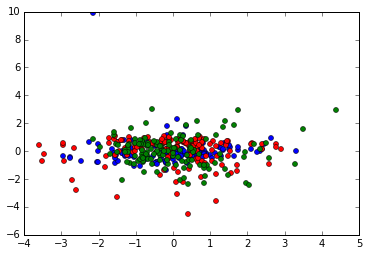

In [53]:
""" sd plot (BLUE) """
plt.plot(sd_transform[:,0],sd_transform[:,1],'o', markersize=5, color='b')

""" sf plot (RED) """
plt.plot(sf_transform[:,0], sf_transform[:,1],'o', markersize=5, color='r')

""" la plot (GREEN) """
plt.plot(la_transform[:,0], la_transform[:,1],'o', markersize=5,color='g')



In [31]:
""" scatter plot sd_transform """

trace0 = go.Scatter(x=la_transform[:,0],y=la_transform[:,1], mode='markers',marker=dict(size=3))

data = [trace0]
py.iplot(data,filename='basic-scatter')

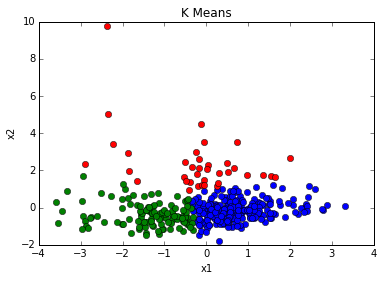

In [55]:
import scipy.cluster.vq as CL
import matplotlib.pyplot as pp

""" Clustering PCA output for all cities """

#number of centroids
numK = 3
centroids, sq = CL.kmeans(np.array(all_transform), numK)

#compute distance of each sample to the centroids
dist = [(np.sum((np.array(all_transform) - np.array([centroids[i]]))**2,1)) for i in range(numK)]

#assign sample to closest cluster
class_assigned = [(np.where(np.transpose(dist)[i]==min(np.transpose(dist)[i])))[0][0] for i in range(all_transform.shape[0])]
clustered = [[all_transform[i] for i, clu in enumerate(class_assigned) if clu == k*1.] for k in range(numK)]

# plotting each class
for k in range(numK):
    pp.plot(np.transpose(clustered[k])[0], np.transpose(clustered[k])[1],'o')

#### CHANGE THESE LABELS TO MATCH YOUR DATA
pp.title('K Means')
pp.xlabel('x1')
pp.ylabel('x2')
pp.show()

In [59]:
""" points assigned to first cluster """




""" still need to find out which year/month/week each data point is from in the cluster...thoughts?"""
clustered[0]

[array([-0.16426288, -1.46278711]),
 array([ 1.29310643, -0.36216294]),
 array([ 1.49939108,  0.18221766]),
 array([ 0.72222722,  0.03063822]),
 array([ 0.07340384, -0.91136918]),
 array([ 0.51386846,  0.04230651]),
 array([ 3.31026541,  0.06073358]),
 array([ 2.44026807,  0.54705173]),
 array([ 1.53153931,  0.33454396]),
 array([ 1.75283331,  0.15703965]),
 array([ 1.23654442,  0.30554017]),
 array([ 0.79781775,  0.64544355]),
 array([ 0.98854616, -0.25418006]),
 array([ 0.75248534, -0.05729836]),
 array([ 1.35226319,  0.14135646]),
 array([ 0.30482435, -0.18643427]),
 array([ 0.67890097,  1.05900541]),
 array([ 2.60512632,  0.98578829]),
 array([ 0.89688735, -0.12632018]),
 array([-0.12398474, -0.28600288]),
 array([ 1.27567386,  0.23917934]),
 array([ 0.51158417,  0.20472066]),
 array([ 0.45617266, -0.29170276]),
 array([ 0.02232798, -0.58418457]),
 array([ 0.60522599, -0.14935665]),
 array([ 0.42412219, -0.30149072]),
 array([-0.15604869, -0.92923168]),
 array([ 1.14159817, -0.1140

In [57]:
""" points assigned to second cluster """
clustered[1]

[array([-1.15697711,  0.79388582]),
 array([-0.66157376, -0.48939412]),
 array([-2.01988372,  0.47148722]),
 array([-2.28312075,  0.634977  ]),
 array([-1.54741541, -0.36483683]),
 array([-0.43254768, -0.80330506]),
 array([-1.54307944, -0.91101184]),
 array([-1.29489279, -0.37055038]),
 array([-2.02297998, -0.02210167]),
 array([-1.64722285,  0.15684945]),
 array([-1.03043633, -1.1523195 ]),
 array([-0.50401643,  0.36442443]),
 array([-1.05114173, -0.48116228]),
 array([-1.45649059, -0.77734879]),
 array([-0.40282712, -0.79724558]),
 array([-0.66822423, -0.51902966]),
 array([-2.02139798, -0.87428017]),
 array([-1.55271573, -0.52349539]),
 array([-1.37626468, -0.19072109]),
 array([-0.79908358, -0.41885061]),
 array([-1.38360924,  0.04405422]),
 array([-2.95512453, -0.42623008]),
 array([-2.74900601, -0.48529859]),
 array([-1.12521398,  0.23186148]),
 array([-1.17506084, -0.39551735]),
 array([-1.09474868, -0.31395621]),
 array([-0.46942708,  0.42889132]),
 array([-2.45107157, -0.7823